### Step 1: explain the data
- what is included
- how it was obtained
- all important details about how it was sampled from the student's own digital archive.

**Objective for draft 1**

**Data Description**




To create a structured dataset of song lyrics, combines data from Spotify and Genius
I start with using Spotify’s API (via the Spotipy library) to extract detailed metadata from my playlists, including track names and artist information. 
With this metadata, I then use the Genius API (accessed through the LyricsGenius library) to search for and retrieve the corresponding lyrics for each song. 
The lyrics that can be found are saved as individual text files in a dedicated folder called 'lyrics'.

By leveraging these public APIs, we automate the extraction and aggregation of diverse musical content, making the dataset creation process efficient and scalable. 
Storing the lyrics locally allows us to apply standard data cleaning and exploratory analysis techniques using libraries like Jieba and pandas. 

In [ ]:
import os
import re
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import lyricsgenius

# -----------------------------
# Configure your API credentials
# -----------------------------
SPOTIPY_CLIENT_ID = 'b24b47adb2a94676bb924ab070b186f9'
SPOTIPY_CLIENT_SECRET = 'eb2285b6e27b4d4886b4f1c4ea008671'
SPOTIPY_REDIRECT_URI = 'http://localhost:8888/callback'
SCOPE = 'playlist-read-private'

GENIUS_ACCESS_TOKEN = '1OtAs6c9WU0RNaQHbO2evkUNLJfexp7n9Yjw1UkiMlM9Eier_lYN20odi0gQZfwu'

# -----------------------------
# Initialize the Spotify and Genius client
# -----------------------------
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=SPOTIPY_CLIENT_ID,
    client_secret=SPOTIPY_CLIENT_SECRET,
    redirect_uri=SPOTIPY_REDIRECT_URI,
    scope=SCOPE
))

genius = lyricsgenius.Genius(GENIUS_ACCESS_TOKEN, timeout=15, sleep_time=1)


def fetch_and_save_lyrics(sp, genius, playlist_id, save_folder):
    # Define the parent 'dataset' folder
    dataset_folder = "dataset"

    # Ensure the 'dataset' folder exists
    if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)

    # Define the full path where lyrics should be saved
    full_save_folder = os.path.join(dataset_folder, save_folder)

    # Check if the lyrics folder exists in 'dataset'
    if not os.path.exists(full_save_folder):
        os.makedirs(full_save_folder)
        print(f"Created folder: {full_save_folder}")
    else:
        print(f"Folder already exists: {full_save_folder}")

    # Path to store previously searched songs
    searched_songs_file = os.path.join(full_save_folder, "searched_songs.txt")

    # Load previously searched songs into a set
    searched_songs = set()
    if os.path.exists(searched_songs_file):
        with open(searched_songs_file, "r", encoding="utf-8") as f:
            searched_songs = set(line.strip() for line in f)

    # Retrieve tracks from the playlist
    results = sp.playlist_items(playlist_id)
    tracks = results['items']

    # Fetch additional pages if available
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])

    # Create a list to store track metadata
    track_list = []

    print("Retrieving tracks from the Spotify playlist:")
    for item in tracks:
        track = item['track']
        track_name = track['name']
        artist_name = track['artists'][0]['name']  # Taking the first artist for simplicity
        track_list.append({'track_name': track_name, 'artist_name': artist_name})
        print(f" - {track_name} by {artist_name}")

    # Fetch and save lyrics for each track using Genius
    print("\nFetching and saving lyrics for each track:")
    for track in track_list:
        track_name = track['track_name']
        artist_name = track['artist_name']

        # Generate a unique key for tracking searches
        song_key = f"{artist_name} - {track_name}"

        # Skip if the song was already searched
        if song_key in searched_songs:
            print(f"Already searched '{track_name}' by {artist_name}. Skipping.")
            continue

        # Sanitize the filename by removing illegal characters
        safe_track_name = re.sub(r'[\\/*?:"<>|]', "", track_name)
        safe_artist_name = re.sub(r'[\\/*?:"<>|]', "", artist_name)
        filename = os.path.join(full_save_folder, f"{safe_artist_name}_{safe_track_name}.txt")

        try:
            # Search for the song on Genius
            song = genius.search_song(track_name, artist_name)

            # Log the search attempt
            with open(searched_songs_file, "a", encoding="utf-8") as f:
                f.write(song_key + "\n")

            if song:
                # Check if the lyrics contain at least one Chinese character
                if not re.search(r'[\u4e00-\u9fff]', song.lyrics):
                    print(f"'{track_name}' by {artist_name} does not appear to be in Chinese. Skipping.")
                    continue
                with open(filename, "w", encoding="utf-8") as f:
                    f.write(song.lyrics)
                print(f"Saved lyrics for '{track_name}' by {artist_name} to {filename}")
            else:
                print(f"Lyrics not found for '{track_name}' by {artist_name}.")
        except Exception as e:
            print(f"Error retrieving lyrics for '{track_name}' by {artist_name}: {e}")

In [ ]:
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:5xyY8qvuTT3bu7I4EZrrK8', "Hopeful")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:26wLPbk8pEGACMWLLQ6zAo', "Breakup")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:5NnmaHZisIOkTSQHrQySkN', "Breakup")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:4Vh7HQNrLVxLTTlHU2HD9G', "nostalgic")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:4wMV6VuktylzFKffYR0NCs', "nostalgic")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:1PVFBy9S4DaoKBwwDydlcg', "Romantic")

While building the dataset, I noticed that Genius did not have lyrics for many Chinese songs—particularly in the “breakup” and “nostalgia” categories. This shortage resulted in an unbalanced dataset, as these categories ended up underrepresented. To address this, I added more songs to increase the total number of samples and to ensure each category is more evenly represented. By expanding the dataset in this way, I aim to provide a more balanced and comprehensive collection of lyrics, which is crucial for training robust classification models.

In [ ]:
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:1N1fFRBzsWliaZper3WB9F', "Breakup")
fetch_and_save_lyrics(sp, genius, 'spotify:playlist:0D3ObU8Bq3FWy7aHjayLf9', "Nostalgic")

### Step 2: Data Ingestion
- converting this data to Python readable format (and sci-kit-learn) 
- loading this data into an appropriate data structure (np.array, pandas dataframe, glob etc.).


In [1]:
import os
import pandas as pd
import glob

def load_lyrics_data(root_folder="dataset"):
    """
    Loads song lyrics from text files stored in category-based subfolders.
    """
    data = []
    for category in os.listdir(root_folder):
        folder = os.path.join(root_folder, category)
        if os.path.isdir(folder):
            for filepath in glob.glob(os.path.join(folder, "*.txt")):
                with open(filepath, 'r', encoding='utf-8') as file:
                    lyrics = file.read().strip()
                data.append({
                    "filename": filepath,
                    "lyrics": lyrics,
                    "label": category
                })
    
    return pd.DataFrame(data)

df = load_lyrics_data()
print("Loaded data:")
print(df.head())

Loaded data:
                                   filename  \
0  dataset/Nostalgic/Hins Cheung_My Way.txt   
1      dataset/Nostalgic/Lolly Talk_三分甜.txt   
2             dataset/Nostalgic/易烊千璽_你說.txt   
3      dataset/Nostalgic/Eason Chan_任我行.txt   
4    dataset/Nostalgic/Eric Chou_小時候的我們.txt   

                                              lyrics      label  
0  3 ContributorsOn my way Lyrics[張敬軒「On my way」歌...  Nostalgic  
1  1 Contributor三分甜 (Triple Sweetness) Lyrics[Lol...  Nostalgic  
2  1 ContributorYou Say – Jackson’s solo (你说 – 易烊...  Nostalgic  
3  1 Contributor任我行 (The Wanderer) Lyrics[陳奕迅「任我行...  Nostalgic  
4  3 Contributors小時候的我們 (When We Were Young) Lyri...  Nostalgic  


Since I've been curating these playlists since 2019, it's possible that I've experienced different emotions for the same song over time, leading me to place it in multiple mood-based folders. To ensure that the categorization remains consistent and that no single song unduly influences any category, I decided to remove duplicate entries from the dataset. This process involved identifying songs with the same file name (indicating they are the same track) across all folders and removing all instances of duplicates. As a result, each song appears only once in the dataset, maintaining clear and distinct boundaries between categories.

In [2]:
# Check for duplicate file names across categories and remove all duplicates
df['basename'] = df['filename'].apply(lambda x: os.path.basename(x))
# Create a boolean mask where True indicates a duplicate (appearing more than once)
duplicates_mask = df['basename'].duplicated(keep=False)

if duplicates_mask.any():
    print("Duplicated file names found. Removing all instances of these duplicates:")
    print(df.loc[duplicates_mask, 'basename'].value_counts())
    # Keep only rows that are not duplicates
    df = df[~duplicates_mask]
else:
    print("No duplicated text file names found across categories.")

Duplicated file names found. Removing all instances of these duplicates:
basename
Dear Jane_到底發生過什麼事.txt     2
Joyce Cheng_我所看見的未來.txt    2
MIRROR_We All Are.txt      2
Cloud 雲浩影_無以名狀的痛.txt       2
Name: count, dtype: int64


In [3]:
print(df['label'].value_counts())

label
Romantic     65
Breakup      62
Hopeful      49
Nostalgic    46
Name: count, dtype: int64


After inspecting the dataset, it became clear that the four mood categories—“inlove,” “breakup,” “comforting,” and “nostalgia”—are not equally represented. For instance, “inlove” and “breakup” have more songs than “comforting” and “nostalgia.” This imbalance can skew the model, causing it to favor the overrepresented categories. Although I attempted to add more songs to the underrepresented categories, there is no guarantee that Genius can find lyrics for all of them, which further complicates the issue.

To handle this, I decided to construct a balanced dataset by using an undersampling approach. Specifically, I reduced each category to match the size of the smallest category. This ensures that each label has the same number of samples, preventing the model from overfitting to any single category and improving the overall reliability of the classification.

In [4]:
from sklearn.utils import resample

def balance_dataset(df, method="undersample"):
    """
    Balances the dataset so that all categories have the same number of samples.
    Options:
    - "undersample": Reduce larger categories to match the smallest one.
    - "oversample": Increase smaller categories to match the largest one.
    """
    if df.empty:
        print("Dataset is empty. Nothing to balance.")
        return df

    category_counts = df['label'].value_counts()
    min_samples = category_counts.min()
    max_samples = category_counts.max()

    if method == "undersample":
        # Reduce all categories to match the smallest one
        df_balanced = df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=min(len(x), min_samples), random_state=42))
    elif method == "oversample":
        # Increase all categories to match the largest one
        df_balanced = df.groupby('label', group_keys=False).apply(lambda x: resample(x, replace=True, n_samples=max_samples, random_state=42))
    else:
        raise ValueError("Invalid balance method. Choose 'undersample' or 'oversample'.")

    return df_balanced.reset_index(drop=True)

df_balanced = balance_dataset(df, method="undersample") 
print("Balanced dataset:")
print(df_balanced['label'].value_counts())


Balanced dataset:
label
Breakup      46
Hopeful      46
Nostalgic    46
Romantic     46
Name: count, dtype: int64


/var/folders/hb/vs0ptz7977jgj7hy5m4jjjt80000gn/T/ipykernel_90294/443425185.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label', group_keys=False).apply(lambda x: x.sample(n=min(len(x), min_samples), random_state=42))


### Step 3: Data Cleaning 
explaining any necessary cleaning, pre-processing, and feature engineering the data requires

+ [code block] completing these steps. 
perform some basic exploratory data analysis at this point reporting and visualizing the samples and computing appropriate descriptive statistics.

#### Data Cleaning:

The Jieba library is a Python tool designed specifically for Chinese text segmentation. 
It provides an efficient and accurate way to break continuous Chinese text into meaningful words for natural language processing (NLP) tasks. 
In projects involving Chinese language data like this, Jieba helps convert raw, unsegmented text into a tokenized format that is suitable for further analysis with machine learning.

One of Jieba's strengths is its ease of use and its ability to handle the unique challenges posed by the Chinese language, where words are not separated by spaces. 
It employs both dictionary-based methods and statistical algorithms to ensure accurate segmentation. 
Although it might not offer the extensive suite of tools available in libraries like NLTK for English text processing, 
Jieba is highly effective for Chinese text and integrates well into workflows that require quick and reliable tokenization for downstream NLP tasks.

The preprocess_lyrics_chinese function transforms raw Chinese song lyrics into a clean, standardized, and tokenized format ready for feature extraction. 
Each step in the process is designed to remove noise, ensure consistency, and prepare the text for effective downstream analysis.

1. Splitting and Header Removal:
When the lyrics is downloaded from genius, it contains a header that signifies the contributor and the title of the song.
To eliminate any extraneous information or metadata (such as titles or headers) that do not contribute to the core lyrical content, this step split the lyrics into individual lines to identigy and remove the header, ensuring that only the main body of the lyrics is processed.

2. Annotation Removal:
The downloaded lyrics also contains annotations (e.g., [Chorus]), and they are not part of the actual lyrical content. 
Removing them helps focus the analysis on the meaningful words and phrases within the song.

3. Rejoining and Punctuation Removal:
The filtered lines are rejoined into a single string, and both Chinese and English punctuation (e.g., commas, periods, exclamation points, parentheses) are removed. 
Since punctuation can interfere with tokenization and analysis by creating unnecessary splits or symbols, removing punctuation creates a smoother text flow for processing.

4. Conversion from Simplified to Traditional Chinese:
The cleaned text is converted from Simplified to Traditional Chinese using OpenCC.
This help standardizing the dataset to ensure that words with the same meaning but different character forms are treated uniformly, allowing accurate tokenization and frequency analysis.

5. Tokenization:
Tokenization is the process of splitting a string of text into individual words or tokens. 
This breaks down the lyrics into manageable units, which is crucial for subsequent steps like filtering and frequency analysis.
Chinese text does not naturally separate words with spaces, and the standardized text is tokenized using the jieba library.

6. Stopword Filtering:
Stopwords are common words that add little semantic value, and they can dilute the significance of the analysis. Tokens are filtered to remove common stopwords, so that the model can focus on the more informative words that are more indicative of the song's themes and content.

7. Filtering by Character Content:
Any token that does not contain at least one Chinese character is removed. This final filtering ensures that the analysis only includes relevant Chinese words, further reducing noise and improving the quality of the token set.

After these preprocessing, the tokens are rejoined into a space-separated string, which is a format well-suited for feature extraction, any subsequent machine learning or text analysis tasks.

In [52]:
import requests

# URL of the Chinese stopwords file (raw file from GitHub)
url = "https://raw.githubusercontent.com/goto456/stopwords/master/cn_stopwords.txt"

# Send a GET request to the URL
response = requests.get(url)

# Check if the download was successful
if response.status_code == 200:
    # Save the content to a file named "chinese_stopwords.txt"
    with open("chinese_stopwords.txt", "w", encoding="utf-8") as f:
        f.write(response.text)
    print("Downloaded Chinese stopwords successfully!")
else:
    print(f"Failed to download Chinese stopwords. Status code: {response.status_code}")

Downloaded Chinese stopwords successfully!


In [5]:
import re
import jieba
import opencc

# Convert from Simplified to Traditional Chinese
converter = opencc.OpenCC('s2t')

def load_chinese_stopwords(filepath):
    """
    Loads Chinese stopwords from a file.
    Assumes one stopword per line.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().split())
    return stopwords

# Load Chinese stopwords from your provided file.
chinese_stopwords = load_chinese_stopwords("chinese_stopwords.txt")

def preprocess_lyrics_chinese(text):
    """
    Preprocess Chinese lyrics by:
    1. Splitting text into lines and optionally discarding a header.
    2. Removing lines with annotations in square brackets (e.g., [Chorus]).
    3. Rejoining the text and removing common Chinese and English punctuation.
    4. Converting text from simplified to traditional Chinese.
    5. Tokenizing using jieba.
    6. Removing stopwords.
    7. Filtering out tokens that do not contain Chinese characters.
    Returns a space-separated string for feature extraction.
    """
    # 1. Split text into lines; remove header if needed
    lines = text.split('\n')
    if len(lines) > 0:
        lines = lines[1:]  # adjust if header is to be discarded

    # 2. Remove lines with annotations like [Chorus]
    filtered_lines = [line for line in lines if not re.search(r'\[.*?\]', line)]
    
    # 3. Rejoin into a single string
    cleaned_text = ' '.join(filtered_lines)
    
    # 4. Remove punctuation: expand to include parentheses and common English punctuation
    punctuation_pattern = r'[，。！？、；：“”‘’《》,!?.:;\'"()\[\]<>-]'
    cleaned_text = re.sub(punctuation_pattern, '', cleaned_text, flags=re.UNICODE)
    
    # 5. Convert simplified Chinese to traditional Chinese
    cleaned_text = converter.convert(cleaned_text)
    
    # 6. Tokenize using jieba
    tokens = jieba.lcut(cleaned_text)
    
    # 7. Remove stopwords
    tokens = [word for word in tokens if word not in chinese_stopwords]
    
    # 8. Filter tokens: keep only tokens that contain at least one Chinese character
    tokens = [word for word in tokens if re.search(r'[\u4e00-\u9fff]', word)]
    
    return " ".join(tokens)


# Apply preprocessing
df_balanced['processed'] = df_balanced['lyrics'].apply(preprocess_lyrics_chinese)
df_balanced['processed'] = df_balanced['processed'].fillna('').astype(str)
print("\nPreprocessed text sample:")
print(df_balanced[['label', 'processed']].head())

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/hb/vs0ptz7977jgj7hy5m4jjjt80000gn/T/jieba.cache
Loading model cost 0.459 seconds.
Prefix dict has been built successfully.



Preprocessed text sample:
     label                                          processed
0  Breakup  我來 城市 走過 來 時 路 想像 著 沒 日子 怎樣 孤獨 尋 得到 塵封 小店 回 不到...
1  Breakup  從 無 力量 狠 慘叫 賣力 照料 得到 敬愛像 親人 情人 其實 喜歡 紛擾 全因 太 對...
2  Breakup  還記 記得 最初 相信 還記 記得 孩子 般 簡單 愛情 我們 彷 彿 天生 一起 用不完 ...
3  Breakup  停 最遠處 送給 祝福 時常夢見 相識 一個 為 披起 婚紗慶祝 連幻覺 痛 卻 心足 聽 ...
4  Breakup  當 想念 慢慢 積攢 變成 一種 負擔 是不是 真的 該放 離開 沒 黑暗 地帶 努力 習慣...


#### Exploratory Data Analysis:

We compute the number of tokens for each song to get an idea of text length and processing success.
Additionally, we visualize the distribution of token counts and compute the most common words across the dataset to understand the general vocabulary and dominant themes present in the lyrics, as well as confirm that the cleaning steps retain relevant content.


Descriptive Statistics:
count    184.000000
mean     312.994565
std       89.331427
min        0.000000
25%      262.000000
50%      308.000000
75%      368.500000
max      554.000000
Name: num_tokens, dtype: float64


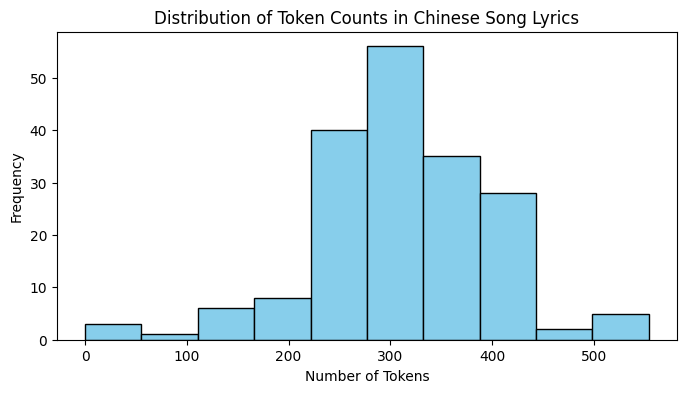


Most Common Words in the Chinese Lyrics Dataset:
說: 470
誰: 459
想: 380
我們: 355
會: 345
讓: 338
後: 305
於: 287
對: 285
愛: 281


In [6]:
import matplotlib.pyplot as plt
from collections import Counter

# Calculate token counts per song (assuming tokens are separated by spaces)
# Convert non-string values or NaNs to an empty string


df_balanced['num_tokens'] = df_balanced['processed'].apply(lambda x: len(x.split()))
print("\nDescriptive Statistics:")
print(df_balanced['num_tokens'].describe())

# Plot token count distribution
plt.figure(figsize=(8, 4))
plt.hist(df_balanced['num_tokens'], bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution of Token Counts in Chinese Song Lyrics")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

# Find most common words across all songs
all_tokens = [token for processed in df_balanced['processed'] for token in processed.split()]
word_counts = Counter(all_tokens)
common_words = word_counts.most_common(10)
print("\nMost Common Words in the Chinese Lyrics Dataset:")
for word, count in common_words:
    print(f"{word}: {count}")

**elab/clarify/change@!!**

The histogram illustrates the distribution of token counts in the Chinese lyrics dataset, with most songs containing between 250 and 400 tokens. 
The distribution appears somewhat right-skewed, indicating a small number of songs with significantly fewer or more tokens than the average. 
This suggests that while most songs fall within a moderate length range, a few outliers have either very short or very long lyrics.

Understanding token count distributions is useful for preprocessing decisions, such as defining length thresholds for filtering or padding sequences in machine learning applications. 
If extreme outliers exist, we might consider normalizing the dataset by excluding excessively short or long songs to maintain consistency in model training.

The most common words in the lyrics dataset include:
說 (say), 誰 (who), 想 (think/want), 後 (after), 我們 (we/us), 著 (with/-ing), 對 (right/towards), 會 (will), 要 (need), 於 (at)
These words indicate common themes in Chinese lyrics:
- Speech and Thought: "說" (say), "誰" (who), "想" (think) suggest a conversational or reflective nature, reinforcing that Chinese songs often explore inner emotions, questions, and relationships.
- Temporal and Relational Concepts: "後" (after) and "於" (at) imply movement through time and space, possibly indicating themes of change, nostalgia, or longing.
- Personal and Collective Identity: "我們" (we) suggests frequent use of first-person plural pronouns, which may imply a strong emphasis on shared experiences, relationships, or group identity.
- Decision and Desire: "會" (will) and "要" (want) point to themes of aspiration, intention, and choice, which are common in both love songs and motivational lyrics.
Since Chinese does not use spaces to separate words, segmentation accuracy significantly impacts frequency counts. 
The observed frequent words may include some function words that are not typically considered stopwords in English NLP but could still be filtered in specific modeling tasks.

In terms of implications for NLP Processing
Stopword Handling: Some high-frequency words like "我們" (we) or "於" (at) may function as stopwords in certain contexts. 
While standard stopword lists exist for Chinese, we may need to customize our stopword list based on the dataset to filter out high-frequency but low-meaning words.

Unlike English, where tokenization is straightforward, Chinese NLP requires careful segmentation.
We should assess whether the current tokenization approach (e.g., Jieba, PKUSEG, Stanford NLP) effectively captures meaningful words or if modifications (custom dictionaries, domain-specific tuning) are necessary.

Since common words alone may not provide sufficient insight, bigrams, trigrams, or contextual embeddings (BERT, Word2Vec, FastText) can help uncover thematic structures in the lyrics. This is particularly useful because a word like "後" could have different meanings depending on context (e.g., "後來" means later, while "最後" means final).

Many of these frequent words could be overrepresented in the chorus due to repetition. 
To avoid misleading frequency-based models, an analysis distinguishing verses from choruses could improve lyrical structure understanding and ensure fair weighting.

### Step 4: Analysis
- discussing the analysis (classification, regression, or clustering) that will be conducted on the data
- code performs any necessary data splits (such as creating training and test sets)

The objective of assignment 1 is to predict which category a song belongs to (comforting, nostalgia, breaking up, or love) based on its lyrics. 

This is a classification problem because the output is a discrete label chosen from a fixed set of categories. 

After balancing and preprocessing the dataset, the data is seperated into training set and test set. This allows for the evaluation of how well the model generalizes to new, unseen data.

The training set help the model to learn patterns and relationships in the lyrics that distinguish one category from another. 
Here, it contains 80% of samples from the entire dataset.

As for the test set, the key idea is that the model does not see these samples during training. 
After the model is trained, it is evaluated on the data in test set to gauge how well it can predict the correct category for songs it has never encountered before.
Here, the remaining 20% of the data is reserved for test set.

The training set is deliberately made larger, so that the model has enough examples to learn from.
At the same time, it is also important to have a sufficiently sized test set to provide a reliable estimate of how the model will perform on real-world data.

In [34]:
from sklearn.model_selection import train_test_split
import numpy as np

# Explanation:
# X contains the processed lyrics (text transformed to a space-separated string after segmentation).
# y contains the corresponding labels (categories such as comforting, growing up, breaking up, love).
# Extract features and labels.
X = df_balanced['processed']  # List of text documents
y = df_balanced['label']  # Class labels as a NumPy array

# We use train_test_split to create a training set and a test set.
# The test_size parameter is set to 0.2, meaning 20% of the data is reserved for testing.
# random_state is set for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the size of each split to confirm
print("Total samples:", len(df_balanced))
print("Training samples:", len(X_train))
print("Test samples:", len(X_test))

Total samples: 184
Training samples: 147
Test samples: 37


**explain why this number is sufficient**

### Step 5: Model Selection

- discuss model** selection** in a markdown section 
- [code] model initialization and construction in a well-commented code block. 
- This section should include a clear discussion of the model's mathematical underpinnings -> include typeset equations and/or algorithms as pseudocode.


##### Naive Bayes

Naive Bayes is a simple yet powerful probabilistic classifier based on Bayes' Theorem. 

Bayes' Theorem is a way to update our beliefs based on new evidence. It tells us how likely a particular class is (for example, "breakup" or "inlove" for a song) given the observed words in the lyrics.

Bayes' Theorem:

$P(C_k \mid x) = \frac{P(x \mid C_k) \, P(C_k)}{P(x)}$   

where

- $P(C_k \mid x)$ refers to the probability that a song belongs to class $C_k $ (e.g., "breakup") given the lyrics $x$
- $P(x \mid C_k)$ refers to the likelihood of observing the lyrics  $x$ if we already knew the song was in class $C_k$
- $P(C_k)$ refers to the prior of how common class $C_k$ is (for example, in this case, the classes are balanced, 25% of our songs are breakup songs, then P(breakup)=0.25).
- $P(x)$ refers to the normalizing constant ensuring that the probabilities for all classes add up to 1.

Because we assume that the tokens are conditionally independent given the class, we can simplify the likelihood $P(x \mid C_k)$ as:

$P(x \mid C_k) \approx \prod_{i=1}^{n} P(x_i \mid C_k)$

where $x_i$ represents the i-th token in the lyrics. 

Since we want choose the class $C_k$ that maximizes posterior probability (i.e., the product of the prior probability and the likelihoods of all the tokens given that class), the final prediction:

$\hat{y} = \arg\max_{k} \, P(C_k) \prod_{i=1}^{n} P(x_i \mid C_k)$




**FIX THIS PART!!**

The term "naive" here refers to the simplified ("naive") assumptions for the model, which is the assumption that all tokens (features) are conditionally independent given the class label. Although this assumption is a simplification, it allows us to quickly estimate the likelihood of observing a particular set of words in a song.

In Multinomial Naive Bayes, it is assumed that the features (e.g., word frequencies or TF–IDF scores) are generated from a multinomial distribution. 
This distribution is ideal for text data, because it explicitly models the probability of observing a certain count for each word given a class. 
It captures how frequently a word appears in a document relative to other documents.

Text data represented by word counts or TF–IDF values is discrete and often sparse (many zeros). Multinomial Naive Bayes is designed for such data. In contrast, Gaussian Naive Bayes assumes that features follow a normal (Gaussian) distribution, which is better suited for continuous numerical data. Since the distribution of word counts is typically skewed and not normally distributed, Gaussian Naive Bayes would not be as effective for our application.

In contrast, Gaussian Naive Bayes assumes that the features follow a normal distribution, which fits continuous numerical data better than it does text data, where the distribution of word counts is often skewed and not normally distributed. It would try to model the frequency as if it were a continuous variable with a mean and variance, which doesn't align well with the inherent properties of textual data.

Therefore, Multinomial Naive Bayes is chosen over Gaussian Naive Bayes, because we are working with text data, which is discrete and often sparse. 



In [ ]:
# --------------------------
# Pseudocode for Naive Bayes Classification
# --------------------------
# Given a document x represented as TF-IDF features:
#
# For each class C_k in the set of possible classes:
#     Compute the prior probability P(C_k) from the training data.
#     For each feature x_i in the document x:
#         Compute the likelihood P(x_i | C_k).
#     Compute the posterior probability:
#         P(C_k | x) ∝ P(C_k) * Π (over i) P(x_i | C_k)
#
# Predict the class that maximizes the posterior probability:
#     y_pred = argmax_k P(C_k | x)
#
# This is essentially what the MultinomialNB implementation does under the hood.

# The nb_pipeline is now ready to be trained on the dataset.
# For example, if X_train contains the song lyrics and y_train contains the corresponding labels,
# you would train the model as follows:
# nb_pipeline.fit(X_train, y_train)

# After training, predictions can be made with:
# y_pred = nb_pipeline.predict(X_test)

In classification tasks, the input data is represented numerically, because most machine learning algorithms work with numerical vectors rather than raw text.
This allows models to detect patterns and associations between word usage and the song’s category, apply learned weights to new, unseen tokens, and use optimization like gradient descent on continuous numerical data.

To convert to numbers, For naive bayes we are using Term Frequency–Inverse Document Frequency (TF‑IDF).

TF‑IDF is used to quantify the importance of a token in a song relative to the entire dataset. 
It helps to weigh down common words while highlighting words that are more distinctive.
For a token $t$ in a document (i.e., a song's lyrics) $d$, TF‑IDF is computed as:

$TF-IDF(t,d)=TF(t,d)×IDF(t,D)$, 

where: 

Term Frequency $\text{TF}(t, d)$ measures how often a token appears in the lyrics of a song, normalized by the total length of the document. 
A higher TF indicates the term is more significant within that document.

$\text{TF}(t, d) = \frac{\text{count}(t, d)}{\sum_{t' \in d} \text{count}(t', d)} = \frac{\text{the number of times a token appears in the song}}{\text{the total number of tokens in the song}}$

Inverse Document Frequency measures how “unique” or “rare” a token is across the entire dataset. 
If a token appears in many songs, the ratio inside the logarithm is smaller, leading to a lower IDF value is lower. 
This reduces the weight of very common words.

$\text{IDF}(t, D) = \log \left( \frac{N}{\left|\{\,d' \in D : t \in d'\}\right|} \right) = \frac{\text{the total number of songs in the entire dataset}}{\text{ the number of songs in which the token appears.}}$


As such, TF emphasizes how important a term is in a particular document, while IDF downweights terms that appear frequently across many documents.

As a result, the text is transformed into a vector where each component represents the TF‑IDF value of a specific term. 
This fixed-length vector can be fed into traditional classifiers like Naive Bayes or MLP.

TF-IDF is chosen over simple word count (i.e., raw frequency) because firstly, raw frequency assigns a higher importance to terms that appear frequently in longer documents, even if those terms are not particularly meaningful.
TF-IDF normalizes term frequency by the total number of words in a document, ensuring that longer lyrics do not automatically have an inflated weight for common words.
Secondly, it also helps reduce the impact of common words. For example, in a lyrics dataset, frequently occurring words would dominate classification if simple word count were used.
TF-IDF reduces the weight of such commonly occurring words across many songs while emphasizing distinctive words that help differentiate song categories (e.g., "童年 (childhood)" for nostalgic).

In [35]:
# Import necessary modules from scikit-learn
from sklearn.pipeline import Pipeline                     # For chaining preprocessing and modeling steps
from sklearn.feature_extraction.text import TfidfVectorizer  # For converting text into TF-IDF feature vectors
from sklearn.naive_bayes import MultinomialNB              # For the Naive Bayes classifier

# --------------------------
# Naive Bayes Pipeline Setup
# --------------------------
# This pipeline consists of two main steps:
# 1. 'tfidf': Converts raw text (song lyrics) into numerical TF-IDF features.
#    - max_features=5000 limits the feature space to the top 5000 terms, reducing noise and computational cost.
# 2. 'clf': Applies the Multinomial Naive Bayes classifier on the TF-IDF features.
#    - MultinomialNB is well-suited for text data and works by estimating the probability of each class
#      based on the frequency of features (words) in the training data.

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  # Step 1: Text to TF-IDF vector conversion.
    ('clf', MultinomialNB())                         # Step 2: Naive Bayes classification.
])

# Training classical models
nb_pipeline.fit(X_train, y_train)

from sklearn.metrics import classification_report

# --- Classical Models ---
# Naive Bayes predictions
y_pred = nb_pipeline.predict(X_test)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

     Breakup       0.80      0.73      0.76        11
     Hopeful       0.55      0.67      0.60         9
   Nostalgic       0.50      0.11      0.18         9
    Romantic       0.50      0.88      0.64         8

    accuracy                           0.59        37
   macro avg       0.59      0.60      0.55        37
weighted avg       0.60      0.59      0.55        37



### Step 6: train the model
- code and explanations for necessary cross validation or hyperparameter tuning.


0.25 for naives bayes 
also cross validation!!

In [ ]:
# Training classical models
nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('clf', MultinomialNB())])

### Step 7: Predictions and Performance
- code to generate predictions for out of sample data, and compute appropriate performance** metrics.**

In [272]:
from sklearn.metrics import classification_report

# --- Classical Models ---
# Naive Bayes predictions
y_pred_nb = nb_pipeline.predict(X_test)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

     breakup       0.75      0.82      0.78        11
  comforting       0.62      0.56      0.59         9
      inlove       0.80      0.89      0.84         9
   nostalgia       0.71      0.62      0.67         8

    accuracy                           0.73        37
   macro avg       0.72      0.72      0.72        37
weighted avg       0.72      0.73      0.72        37



**interpret what each of them mean!!!**

### Step 8: Results
- visualize the results and discuss your conclusions.

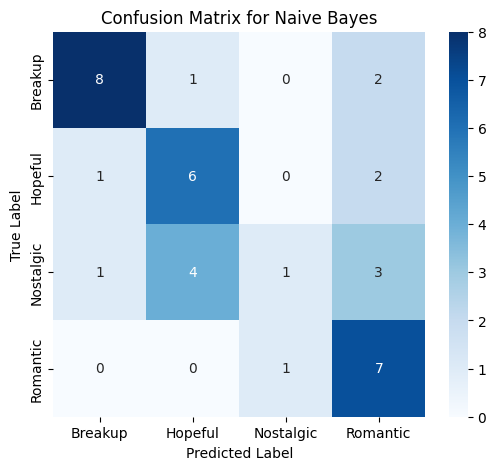

In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Define class names
class_names = ['Breakup', 'Hopeful', 'Nostalgic','Romantic']  # Replace with your actual class labels

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap with correct labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### k-fold cross-validation

Cross-validation is a technique used to estimate how well a model generalizes to unseen data by splitting the training data into multiple “folds” ($k$). 
Rather than training and evaluating the model on a single train/test split, cross-validation cycles through different partitions of the training set as mini-train/validation sets, then averages the performance across these partitions.

This provides a more reliable performance estimates, because a single train/test split might accidentally favor the model or fail to capture its weaknesses, especially with a small dataset (184 songs in this case). Cross-validation helps mitigate this variance by averaging results across multiple splits.
Also, when tuning hyperparameters, there is a risk of overfitting to a single validation set. By using multiple folds, we can reduce the likelihood of “over‐fitting” to peculiarities in a single split.

The value of $k$ is selected to be 5, meaning that each fold contains roughly $\frac{1}{5}$ of the training data.
With only 147 training samples, 5-fold CV ensures each fold is still large enough to provide stable estimates. A higher $k$ like 10-fold could be used, but it might start introducing higher variance in each fold’s estimate, and the training overhead would double.

Below are the hypermeter chosen for tuning:

TF-IDF Vectorizer:
- max_features: controls how many terms (words, tokens) to keep in the vocabulary. Too few features can miss important words, too many might include noise. Values like None, 5000, and 10000 let us see if restricting the vocabulary helps or hurts performance.
- ngram_range: Decides whether to consider single words only (1,1) or pairs of words (1,2). As mentioned in EDA, sometimes bigrams capture phrases like a word like "後" could have different meanings depending on context (e.g., "後來" means later, while "最後" means final) more effectively.
- sublinear_tf: When it is set to be "True", it uses $1+log(tf)$ instead of raw term frequency. This can help if raw frequency skews the importance of very common words.

Naive Bayes:
- $\alpha$: This is for Laplace smoothing. Values like 0.1, 1.0, and 5.0 control how much we smooth zero counts. 
A smaller $\alpha$ relies more on observed data; a larger $\alpha$ flattens probabilities more aggressively. 
Since Naive Bayes is relatively simple, $\alpha$ can still significantly affect performance.

In [37]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report

# Define the grid of hyperparameters to search over.
param_grid = {
    'tfidf__max_features': [None, 5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__sublinear_tf': [False, True],
    'clf__alpha': [0.1, 1.0, 5.0]
}

# Use stratified 5-fold cross-validation to ensure class proportions are preserved in each fold.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV with the macro F1-score (multiclass) as our scoring metric.
grid_search = GridSearchCV(nb_pipeline, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)

# Fit GridSearchCV on the training data.
grid_search.fit(X_train, y_train)

# Print the best parameters and best cross-validation score.
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation macro F1-score:", grid_search.best_score_)

# Evaluate the best model on the test set.
best_model = grid_search.best_estimator_
y_pred_k = best_model.predict(X_test)
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_k))

Best parameters found: {'clf__alpha': 0.1, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1), 'tfidf__sublinear_tf': True}
Best cross-validation macro F1-score: 0.606786106050812
Classification Report on Test Set:
              precision    recall  f1-score   support

     Breakup       0.62      0.91      0.74        11
     Hopeful       0.64      0.78      0.70         9
   Nostalgic       1.00      0.33      0.50         9
    Romantic       0.71      0.62      0.67         8

    accuracy                           0.68        37
   macro avg       0.74      0.66      0.65        37
weighted avg       0.74      0.68      0.66        37



Comparing to the initial single test split, we see a drop in the final single-test-set accuracy (from 0.73 to 0.62).
However, this does not necessarily indicate that the cross-validated model is objectively “worse.” 
Instead, since cross-validation averages performance across several partitions of the training set, it reduces the chance that the model’s reported performance is inflated by a single favorable split. 
Thus, this can imply that the model may have inadvertently overfitted to the particular train/test division, such that the higher accuracy (0.73) might partially stem from a lucky split that can be over-optimistic and did not reflect the model’s true behavior on unseen data. 
This process is particularly important when dealing with this relatively small dataset (184 songs total).

While hyperparameter tuning often improves performance, Naive Bayes is inherently robust with few parameters. 
In some cases, especially with a small dataset, tuning can yield parameter combinations that generalize well on average but do not match a single final test set’s distribution. 
Hence, the best cross-validation F1-score (about 0.624) might be more representative of how the model performs in a variety of train/test scenarios, even though it scores 0.62 accuracy on this particular test split.

#### Building from scratch

To further my understanding of the model's mechanism and code, I built the Naive Bayes text classifier from scratch.
This version manually computes class priors and conditional probabilities without relying on external scikit-learn’s built-in Naive Bayes libraries. 

The classifier is specifically designed to work with TF-IDF features instead of raw word counts, meaning that instead of treating term frequencies as direct feature counts, it scales features based on their informativeness across the dataset. 
This avoids giving too much weight to highly frequent but uninformative words and instead prioritizes words that uniquely characterize a given class. 
The way this is achieved in the model is through computing conditional probabilities not over raw counts of words, but over the sum of TF-IDF scores per class. 
As a result, the probability of a word in a class depends on its weighted presence rather than simple occurrence frequency.

During training (fit method), it begins by computing class prior probabilities $P(c)$, which represent how frequently each class appears in the dataset. 
Next, for each class, the TF-IDF values of all documents belonging to that class are summed to create a representation of feature importance per class. 
Laplace smoothing is applied to prevent zero probabilities for unseen words. 
This is necessary because, in probabilistic models, a zero probability for any feature (word) in a class would cause the entire class probability computation to be zero when using multiplication (or negative infinity when working with log probabilities). 
To prevent this, we add a small constant $\alpha = 1$ to every probability calculation. 
Choosing $\alpha = 1$ represents "add-one smoothing," which ensures that every feature has at least some probability mass, avoiding division by zero issues and preventing extreme biases in classification. 
While alternative values for $\alpha$ (e.g., 0.1 or 10) could be used to fine-tune the degree of smoothing, $\alpha = 1$ is a commonly used default that balances smoothing without overly distorting word importance.
The model then normalizes these smoothed values to obtain the conditional probability $P(feature∣c)$, which estimates the likelihood of each word given a class.

During prediction (predict method), the model evaluates each document by computing the log probability of belonging to each class. 
This is done by summing the log prior probability $logP(c)$ and the weighted sum of log conditional probabilities $\sum_{j} \text{TF-IDF}_j \cdot \log P(\text{word}_j \mid c)$. 
This formulation means that words with higher TF-IDF scores in a document contribute more significantly to the final probability of a class, emphasizing distinguishing terms rather than common stopwords. 
The class with the highest computed probability is chosen as the predicted label. 
This approach ensures that the model effectively balances prior knowledge of class distributions with the importance of words in each document.

One strength of implementing Naive Bayes from scratch is the flexibility it offers for customization. 
For example, in this implementation, the way conditional probabilities are computed has been modified to work specifically with TF-IDF rather than raw word counts. 
Additionally, the smoothing parameter $\alpha$ is explicitly set, allowing for experimentation with different values to observe their effects on classification. 

Another area of customization is in how probabilities are computed: instead of working in the traditional count-based space, we modify the denominator of the probability calculation to normalize by the total TF-IDF sum per class, ensuring the model properly accounts for the weighted nature of TF-IDF features. This level of control allows further optimizations, such as adjusting how much TF-IDF weight should influence probability calculations, or modifying how log probabilities are aggregated.

In [38]:
# Custom Naive Bayes classifier built from scratch
class CustomNaiveBayes:
    def __init__(self, alpha=1.0):
        """
        Initialize the classifier with a smoothing parameter.
        
        :param alpha: Laplace smoothing parameter to avoid zero probabilities.
        """
        self.alpha = alpha               # Laplace smoothing parameter
        self.class_priors = {}           # Dictionary to store prior probabilities for each class
        self.feature_prob = None         # Conditional probability matrix: shape (n_classes, n_features)
        self.classes = None              # Array of unique class labels

    def fit(self, X, y):
        """
        Train the Naive Bayes classifier using the provided TF-IDF feature matrix and labels.
        
        :param X: TF-IDF feature matrix (sparse matrix) where rows correspond to documents.
        :param y: Array-like of class labels for each document.
        """
        # Get the total number of documents and features
        n_docs, n_features = X.shape
        
        # Identify the unique classes and count how many there are
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Compute prior probabilities for each class: P(c) = (# documents in class c) / (total documents)
        self.class_priors = {c: np.sum(y == c) / float(n_docs) for c in self.classes}

        # Initialize an array to accumulate the sum of TF-IDF values per feature for each class.
        # This array has shape (n_classes, n_features)
        feature_sum = np.zeros((n_classes, n_features))
        
        # Loop over each class and sum the TF-IDF values for documents that belong to that class.
        for idx, c in enumerate(self.classes):
            # Get indices of documents that belong to class c
            indices = np.where(y == c)[0]
            # Sum the TF-IDF values along the document axis for class c
            # Convert the result to a flat array
            feature_sum[idx, :] = np.array(X[indices].sum(axis=0)).flatten()

        # Apply Laplace smoothing: add alpha to each "feature count" (here, weighted by TF-IDF)
        smoothed_fc = feature_sum + self.alpha
        
        # Compute the total sum of TF-IDF values per class after smoothing
        class_feature_sum = smoothed_fc.sum(axis=1)  # shape: (n_classes,)

        # Calculate the conditional probability for each feature given the class:
        # P(feature | class) = (smoothed TF-IDF count for feature) / (total smoothed TF-IDF count for class)
        self.feature_prob = smoothed_fc / class_feature_sum[:, np.newaxis]

    def predict(self, X):
        """
        Predict class labels for the given TF-IDF feature matrix.
        
        :param X: TF-IDF feature matrix (numpy array) for test documents.
        :return: Numpy array of predicted class labels.
        """
        predictions = []
        # Iterate over each document in the test set
        for i in range(X.shape[0]):
            # Directly use the row if X is a NumPy array
            # If it's sparse, you could use X[i].toarray().flatten()
            x_i = X[i, :].flatten()  
            log_probs = []
            
            # Compute the log probability for each class for this document.
            for idx, c in enumerate(self.classes):
                log_prob = np.log(self.class_priors[c])
                log_prob += np.sum(x_i * np.log(self.feature_prob[idx, :]))
                log_probs.append(log_prob)
            
            # The predicted class is the one with the highest computed log probability.
            predictions.append(self.classes[np.argmax(log_probs)])
        return np.array(predictions)



In [39]:
import math

class CustomTfidfVectorizer:
    def __init__(self,
                 max_features=None,
                 norm='l2',
                 sublinear_tf=False,
                 token_pattern=r'(?u)\b\w\w+\b'):
        """
        A custom TF-IDF vectorizer that approximates scikit-learn's defaults.

        :param max_features: Maximum number of terms to keep in the vocabulary.
        :param norm: The normalization to apply to each document vector ('l1', 'l2', or None).
        :param sublinear_tf: If True, replace term frequency tf with 1 + log(tf).
        :param token_pattern: Regex pattern to match tokens (similar to scikit-learn).
        """
        self.max_features = max_features
        self.norm = norm
        self.sublinear_tf = sublinear_tf
        self.token_pattern = re.compile(token_pattern)
        self.vocabulary_ = {}
        self.idf_ = {}

    def _tokenize(self, text):
        """
        Tokenize the input text using the specified regex pattern,
        converting to lowercase and matching words of length >= 2.
        """
        return self.token_pattern.findall(text.lower())

    def fit(self, documents):
        """
        Learn the vocabulary and idf from the training documents.

        :param documents: List of raw text documents.
        """
        n_docs = len(documents)
        term_doc_freq = {}

        # Build document frequency
        for doc in documents:
            tokens = set(self._tokenize(doc))
            for token in tokens:
                term_doc_freq[token] = term_doc_freq.get(token, 0) + 1

        # Sort terms by document frequency (descending)
        sorted_terms = sorted(term_doc_freq.items(), key=lambda x: x[1], reverse=True)

        # Limit vocabulary if max_features is specified
        if self.max_features:
            sorted_terms = sorted_terms[:self.max_features]

        # Build the vocabulary
        self.vocabulary_ = {term: idx for idx, (term, _) in enumerate(sorted_terms)}

        # Compute IDF with smoothing: idf = log((n_docs + 1) / (df + 1)) + 1
        for term, df in sorted_terms:
            self.idf_[term] = math.log((n_docs + 1) / (df + 1)) + 1

    def transform(self, documents):
        """
        Transform documents into a TF-IDF feature matrix.

        :param documents: List of raw text documents.
        :return: A numpy array of shape (n_documents, n_features) with TF-IDF values.
        """
        n_docs = len(documents)
        n_features = len(self.vocabulary_)
        X = np.zeros((n_docs, n_features), dtype=np.float64)

        for i, doc in enumerate(documents):
            tokens = self._tokenize(doc)
            term_counts = {}
            for token in tokens:
                if token in self.vocabulary_:
                    term_counts[token] = term_counts.get(token, 0) + 1

            total_terms = sum(term_counts.values())
            for term, count in term_counts.items():
                idx = self.vocabulary_[term]
                # Compute TF
                if self.sublinear_tf:
                    # Sublinear TF: tf = 1 + log(count)
                    tf = 1 + math.log(count) if count > 0 else 0
                    # If you do sublinear TF, you often don't normalize by total_terms
                    # but scikit-learn's default is to ignore total_terms in sublinear mode
                else:
                    # Standard TF
                    tf = count / total_terms if total_terms > 0 else 0

                # Multiply by IDF
                X[i, idx] = tf * self.idf_[term]

        # Apply L2 normalization if specified
        if self.norm == 'l2':
            row_norms = np.linalg.norm(X, axis=1)
            non_zero_rows = (row_norms != 0)
            X[non_zero_rows] = X[non_zero_rows] / row_norms[non_zero_rows][:, np.newaxis]

        return X

    def fit_transform(self, documents):
        """
        Fit to the data and transform it into a TF-IDF matrix in one step.

        :param documents: List of raw text documents.
        :return: TF-IDF feature matrix.
        """
        self.fit(documents)
        return self.transform(documents)

In [40]:
# Use TfidfVectorizer to convert text to TF-IDF features.
vectorizer = CustomTfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create an instance of the custom Naive Bayes classifier and train it on the TF-IDF features.
custom_nb = CustomNaiveBayes(alpha=1.0)
custom_nb.fit(X_train, y_train)

# Predict class labels for the test set.
y_pred_custom = custom_nb.predict(X_test)

# Evaluate the model.
print("Custom Naive Bayes with TF-IDF Classification Report:")
print(classification_report(y_test, y_pred_custom))

Custom Naive Bayes with TF-IDF Classification Report:
              precision    recall  f1-score   support

     Breakup       0.80      0.73      0.76        11
     Hopeful       0.60      0.67      0.63         9
   Nostalgic       0.67      0.22      0.33         9
    Romantic       0.50      0.88      0.64         8

    accuracy                           0.62        37
   macro avg       0.64      0.62      0.59        37
weighted avg       0.65      0.62      0.60        37



Accuracy differs by only 3 percentage points (0.59 vs. 0.62).
Macro-average F1-scores differ by 4 points (0.55 vs. 0.59).
Per-class performance is nearly identical for “Breakup” and “Romantic,” with some variation in “Hopeful” and “Nostalgic.”

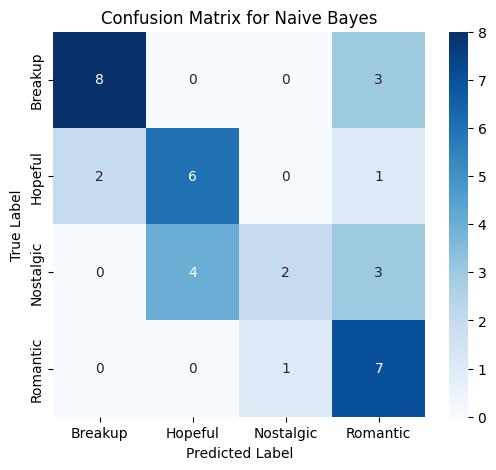

In [41]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Define class names
class_names = ['Breakup', 'Hopeful', 'Nostalgic','Romantic']  # Replace with your actual class labels

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_custom)

# Plot the heatmap with correct labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix for Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### interpret!!!

#### Extension

see whether there will be improvemnet 
- explain what BERT is
- strengths and weaknesse --> why do i think it'd be better
- analyze the results and compare

### Step 9: executive summary (of the prior eight sections)
- clearly explaining your steps
- diagramming your pipeline
- visualizing any key results
- explaining any key insights or shortcomings of your approach. 
- You may wish to include a discussion of how the model might be improved.


- increase size of data size --> more confident in the accuracy

### Step 10: references 
- documents, guides, or code repos you accessed for the project.